In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression

# зафиксируем значение генератора случайных чисел для воспроизводимости 
SEED = 1
# Функции, которые в дальнейшем понадобятся
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

def grid_search(model, gs_params):
    '''Функция для подбора гиперпараметров с помощью перекрёстной проверки'''
     
    gs = GridSearchCV(estimator=model, param_grid=gs_params, refit=True,
                      scoring='roc_auc', n_jobs=-1, cv=skf, verbose=0)
    gs.fit(X, y)
    scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
           \nbest params = {}'.format(scores,
                                      gs.cv_results_['mean_test_score'][gs.best_index_],
                                      gs.cv_results_['std_test_score'][gs.best_index_],
                                      gs.best_params_))
    return gs
        
# загрузим данные        
df = pd.read_csv('adult.data.csv')

# датасет, с которым будем работать
# оставим только численые признаки
X = df.select_dtypes(exclude=['object']).copy()
# преобразуем целевую переменную
y = df['salary'].apply(lambda x: 0 if '<=50K' else 1).values

X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


scores = [nan nan nan nan nan] 
mean score = nan +/- nan


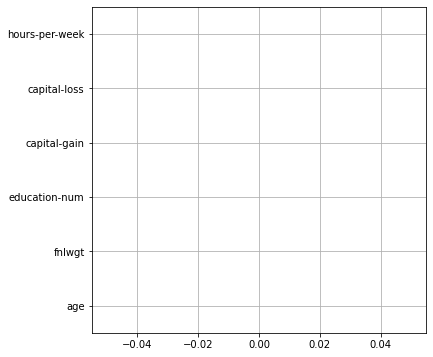

In [28]:
rf = Pipeline([('rf', RandomForestClassifier(n_jobs=-1, 
                                             class_weight='balanced', 
                                             random_state=SEED))])

# параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scores = cross_val_score(estimator=rf, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

# важность признаков
plot_features_scores(model=rf, data=X, target=y, column_names=X.columns, model_type='rf')

In [ ]:
lr = Pipeline([('p_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=SEED)
               )])
scores = cross_val_score(estimator=lr, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

plot_features_scores(model=lr, data=X, target=y, column_names=X.columns, model_type='lr')

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,norm_0,unif_0,lapl_0,norm_1,unif_1,lapl_1,norm_2,unif_2,lapl_2,norm_3,unif_3,lapl_3
0,39,77516,13,2174,0,40,0.246454,4.996750,2.311467,6.474587,6.431455,-0.932124,3.773136,3.382773,-1.324387,8.031167,2.142457,8.050902
1,50,83311,13,0,0,13,-4.656718,4.693542,2.095298,14.622329,2.795007,6.465348,-3.275117,3.787041,0.652694,7.537461,5.247103,9.014559
2,38,215646,9,0,0,40,12.788669,4.255611,22.278713,9.643720,3.533265,2.716441,4.725608,3.126107,23.410698,1.932907,4.933431,13.233319
3,53,234721,7,0,0,40,-15.713848,3.989797,5.971506,8.978198,7.772238,-5.402306,5.742672,3.084132,0.937932,9.435720,4.915537,-3.396526
4,28,338409,13,0,0,40,20.703306,3.159246,8.718559,8.217148,4.365603,14.403088,3.023828,6.934299,4.978327,7.355296,2.551361,10.479218


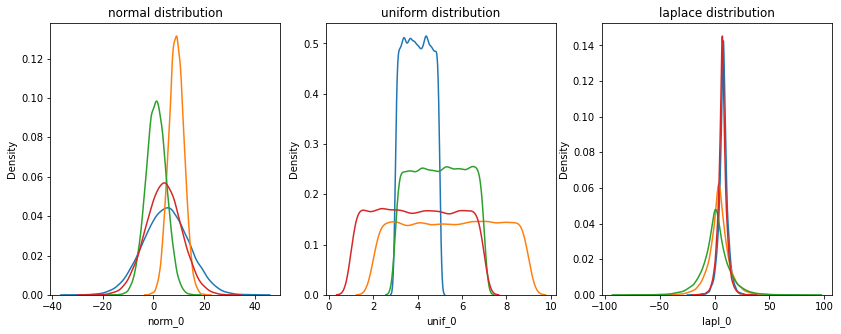

In [33]:
# утановим значение генератора случайных чисел для воспроизводимости
np.random.seed(SEED)

fix, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
ax1.set_title("normal distribution")
ax2.set_title("uniform distribution")
ax3.set_title("laplace distribution")
for i in range(4):
    X.loc[:, f'norm_{i}'] = np.random.normal(loc=np.random.randint(low=0, high=10), 
                                             scale=np.random.randint(low=1, high=10), 
                                             size=(X.shape[0], 1))
    
    X.loc[:, f'unif_{i}'] = np.random.uniform(low=np.random.randint(low=1, high=4), 
                                              high=np.random.randint(low=5, high=10), 
                                              size=(X.shape[0], 1))
    X.loc[:, f'lapl_{i}'] = np.random.laplace(loc=np.random.randint(low=0, high=10), 
                                              scale=np.random.randint(low=1, high=10), 
                                              size=(X.shape[0], 1))
    # визуализирукем распределения признаков
    sns.kdeplot(X[f'norm_{i}'], ax=ax1)
    sns.kdeplot(X[f'unif_{i}'], ax=ax2)
    sns.kdeplot(X[f'lapl_{i}'], ax=ax3)

# итоговый датасет
X.head()

scores = [nan nan nan nan nan] 
mean score = nan +/- nan


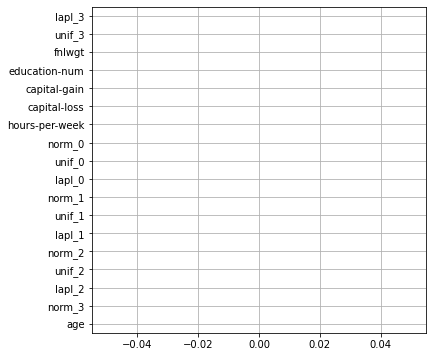

In [34]:
scores = cross_val_score(estimator=rf, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))
plot_features_scores(model=rf, data=X, target=y, column_names=X.columns, model_type='rf')

In [3]:
a = (1,2,3,4,5)
b = a[2:]
b[100:]

()